In [1]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models import Resnet18
from tcav import TCAV
from model_wrapper import ModelWrapper
from mydata import MyDataset, ValidateDataset
import os
import prettytable as pt
import numpy as np

/cis/home/ashen7/anaconda3/envs/mdd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def data_loader(base_path):
    image_dataset_train = MyDataset(base_path, transform=data_transforms)
    train_loader = DataLoader(image_dataset_train, batch_size=1)
    return train_loader

In [5]:
def train():
    best_weights = model.state_dict()
    best_acc = 0.0
    for epoch in range(100):
        # test phase
        total = 0
        score = 0
        with torch.no_grad():
            model.eval()
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.max(dim=1)[1]
                total += labels.size(0)
                score += predicted.eq(labels).sum().item()
        acc = score / total
        print("epoch: {}\tacc: {}".format(epoch, acc))
        if acc > best_acc:
            best_acc = acc
            best_weights = model.state_dict()

        # train phase
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # save model parameters
    torch.save(best_weights, 'resnet18_T8.pth')

In [25]:
def validate(model):
    model.eval()
    weights = torch.load('/cis/home/ashen7/TCAV_EEG/tcav/resnet18_T8.pth')

    model.load_state_dict(weights)
    extract_layer = 'feature_layers'
    model = ModelWrapper(model, [extract_layer])

    scorer = TCAV(model, validloader, concept_dict, class_dict.values(), 150)

    print('Generating concepts...')
    scorer.generate_activations([extract_layer])
    scorer.load_activations()
    print('Concepts successfully generated and loaded!')

    print('Calculating TCAV scores...')
    scorer.generate_cavs(extract_layer)
    scorer.calculate_tcav_score(extract_layer, 'output/tcav_result.npy')
    scores = np.load('output/tcav_result.npy')
    scores = scores.T.tolist()
    print('Done!')

    table = pt.PrettyTable()
    table.field_names = ['class'] + list(concept_dict.keys())
    for i, k in enumerate(class_dict.keys()):
        new_row = [k] + scores[i]
        table.add_row(new_row)
    print(table)
    

In [26]:
if __name__ == "__main__":
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    data_transforms = transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    image_dataset = datasets.ImageFolder('/cis/home/ashen7/TCAV_EEG/data/eeg_diagnosis', data_transforms)
    train_size = int(len(image_dataset) * 0.8)
    train_data, test_data = torch.utils.data.random_split(image_dataset, [train_size, len(image_dataset) - train_size])
    trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
    testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

    class_dict = {
        'low':  0,
        'high': 1
    }

    reverse_class_dict = {v : k for k, v in class_dict.items()}

    validate_dataset = ValidateDataset(class_dict.values(), trainloader)
    validloader = DataLoader(validate_dataset, batch_size=1, shuffle=False, num_workers=1)

    concept_dict = {}
    for dirname in os.listdir('/cis/home/ashen7/TCAV_EEG/data/concepts_eeg'):
        fullpath = os.path.join('../data/concepts_eeg', dirname)
        if os.path.isdir(fullpath):
            concept_dict[dirname] = data_loader(fullpath)
    print(concept_dict)


    model = Resnet18(output_num=2)
    model = model.to(device)
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    train()
    # validate(model)



{'beta': <torch.utils.data.dataloader.DataLoader object at 0x7fd263467a60>, 'delta': <torch.utils.data.dataloader.DataLoader object at 0x7fd2482a9460>, 'gamma': <torch.utils.data.dataloader.DataLoader object at 0x7fd2482a9760>, 'theta': <torch.utils.data.dataloader.DataLoader object at 0x7fd2482a91c0>, 'alpha': <torch.utils.data.dataloader.DataLoader object at 0x7fd2482a9100>}


/Users/ashen/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ashen/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Generating concepts...


/Users/ashen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Concepts successfully generated and loaded!
Calculating TCAV scores...
5
['beta', 'delta', 'gamma', 'theta', 'alpha']


Calculating tcav score for alpha: 100%|██████████| 430/430 [00:11<00:00, 36.99it/s]

Done!
+-------+---------------------+---------------------+---------------------+----------------------+---------------------+
| class |         beta        |        delta        |        gamma        |        theta         |        alpha        |
+-------+---------------------+---------------------+---------------------+----------------------+---------------------+
|  low  | 0.26424870466321243 | 0.46632124352331605 | 0.35751295336787564 | 0.031088082901554404 |  0.9948186528497409 |
|  high |  0.4936708860759494 |  0.4472573839662447 |  0.5063291139240507 |  0.9113924050632911  | 0.05063291139240506 |
+-------+---------------------+---------------------+---------------------+----------------------+---------------------+


In [27]:
concept = list(concept_dict.keys())
print(concept)
print(len(concept))

classes = list(class_dict.keys())
print(classes)
print(len(classes))

scores = np.load('output/tcav_result.npy')
print(scores)
print(scores.shape)

['beta', 'delta', 'gamma', 'theta', 'alpha']
5
['low', 'high']
2
[[0.2642487  0.49367089]
 [0.46632124 0.44725738]
 [0.35751295 0.50632911]
 [0.03108808 0.91139241]
 [0.99481865 0.05063291]]
(5, 2)


In [14]:
scores[:,0]

array([1.        , 0.        , 0.38356164, 1.        , 0.        ])

Text(0.5, 1.0, 'Relative TCAV score for LOW severity MDD patients')

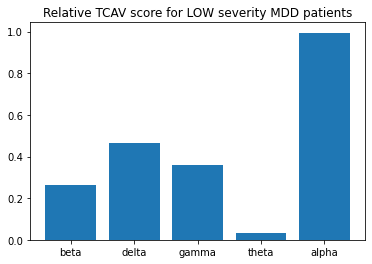

In [28]:
import matplotlib.pyplot as plt
plt.bar(concept, scores[:,0])
plt.title('Relative TCAV score for LOW severity MDD patients')

Text(0.5, 1.0, 'Relative TCAV score for HIGH severity MDD patients')

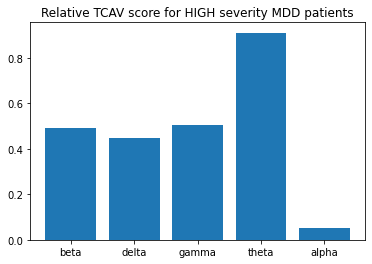

In [29]:
plt.bar(concept, scores[:,1])
plt.title('Relative TCAV score for HIGH severity MDD patients')

In [8]:
scores_adjust = np.zeros((len(concept), len(classes)))
scores_adjust[0] = scores[1]
scores_adjust[1] = scores[7]
scores_adjust[2] = scores[8]
scores_adjust[3] = scores[0]
scores_adjust[4] = scores[2]
scores_adjust[5] = scores[3]
scores_adjust[6] = scores[4]
scores_adjust[7] = scores[5]
scores_adjust[8] = scores[6]
print(scores_adjust)

IndexError: index 7 is out of bounds for axis 0 with size 5

In [9]:
concepts_adjust = 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Backpack', 'Bike', 'Bookcase', 'Helmet'

ValueError: shape mismatch: objects cannot be broadcast to a single shape

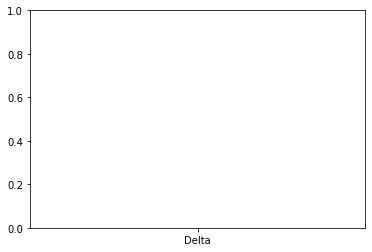

In [14]:
import matplotlib.pyplot as plt

plt.bar(concepts_adjust, scores_adjust[:,0])
plt.title('TCAV score for {} MDD severity'.format(classes[0]), fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Concepts', fontsize=12)

Text(0.5, 0, 'Concepts')

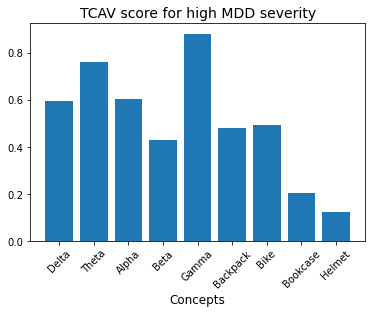

In [32]:
plt.bar(concepts_adjust, scores_adjust[:,1])
plt.title('TCAV score for {} MDD severity'.format(classes[1]), fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Concepts', fontsize=12)

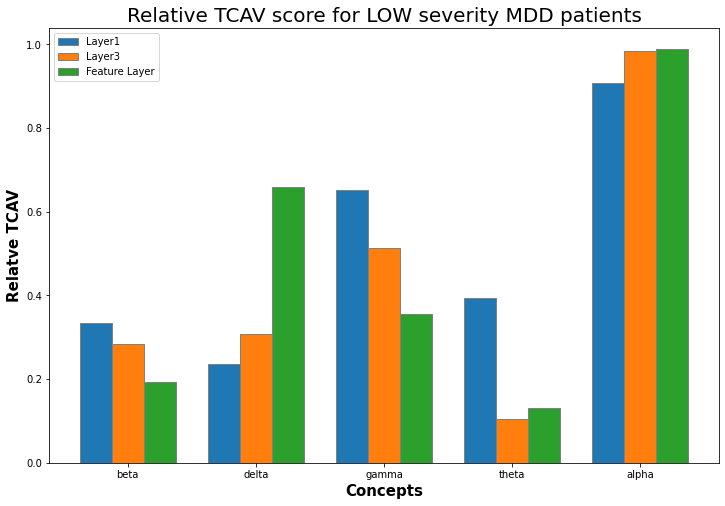

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
layer1 = [0.3333, 0.2358, 0.6513, 0.3948, 0.9076]
layer3 = [0.2827, 0.3089, 0.5130, 0.1047, 0.9843]
feature_layer = [0.1937, 0.6596, 0.3560, 0.1308, 0.9895]

# Set position of bar on X axis
br1 = np.arange(len(layer1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, layer1, width = barWidth,
		edgecolor ='grey', label ='Layer1')
plt.bar(br2, layer3, width = barWidth,
		edgecolor ='grey', label ='Layer3')
plt.bar(br3, feature_layer, width = barWidth,
		edgecolor ='grey', label ='Feature Layer')

# Adding Xticks
plt.xlabel('Concepts', fontweight ='bold', fontsize = 15)
plt.ylabel('Relatve TCAV', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(layer1))],
		['beta', 'delta', 'gamma', 'theta', 'alpha'])
plt.title('Relative TCAV score for LOW severity MDD patients', fontsize=20)
plt.legend()
plt.show()


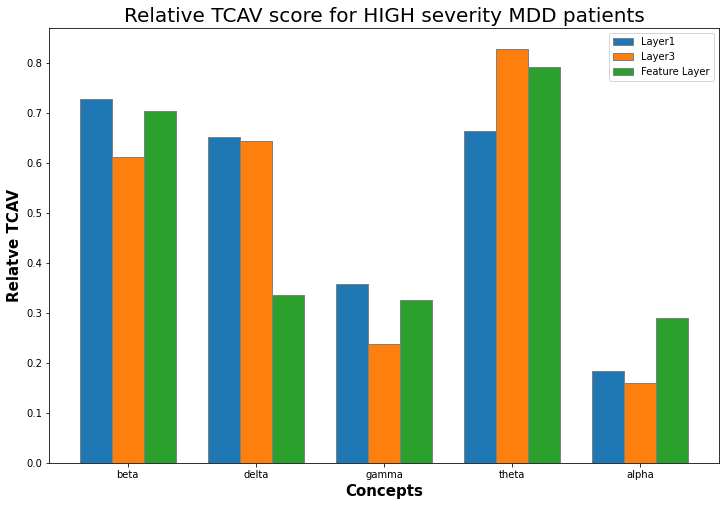

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
layer1 = [0.7276, 0.6511, 0.3574, 0.6638, 0.1829]
layer3 = [0.6108, 0.6443, 0.2385, 0.8284, 0.1590]
feature_layer = [0.7029, 0.3347, 0.3263, 0.7908, 0.2887]

# Set position of bar on X axis
br1 = np.arange(len(layer1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, layer1, width = barWidth,
		edgecolor ='grey', label ='Layer1')
plt.bar(br2, layer3, width = barWidth,
		edgecolor ='grey', label ='Layer3')
plt.bar(br3, feature_layer, width = barWidth,
		edgecolor ='grey', label ='Feature Layer')

# Adding Xticks
plt.xlabel('Concepts', fontweight ='bold', fontsize = 15)
plt.ylabel('Relatve TCAV', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(layer1))],
		['beta', 'delta', 'gamma', 'theta', 'alpha'])
plt.title('Relative TCAV score for HIGH severity MDD patients', fontsize=20)
plt.legend()
plt.show()
